# ART for TensorFlow v2 - Callable Class/Function

This notebook demonstrates applying ART with TensorFlow v2 using callable classes or functions to define models. The code follows and extends the examples on www.tensorflow.org.

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
import numpy as np
from matplotlib import pyplot as plt

from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod, CarliniLInfMethod

In [3]:
if tf.__version__[0] != '2':
    raise ImportError('This notebook requires TensorFlow v2.')

# Load MNIST dataset

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

x_test = x_test[0:10]
y_test = y_test[0:10]

11490434/11490434 [==============================] - 0s 0us/step


Add a dimension for color channel

In [5]:
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

Create loss object and optimizer

In [6]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

Define metrics for training and testing

In [7]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# TensorFlow with callable class

Create a custom model class.

In [8]:
class KerasModel(Model):
    def __init__(self):
        super(KerasModel, self).__init__()
        self.conv1 = Conv2D(filters=3, kernel_size=3, activation='relu')
        self.flatten = Flatten()
        self.dense1 = Dense(10, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.dense1(x)
        return x

Create callable model

In [9]:
model = KerasModel()

Create input pipelines for training and testing

In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

Define the training step.

In [11]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

Define the testing step.

In [12]:
@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

Fit the model on training data and collect metrics for training and testing.

In [13]:
epochs = 3

for epoch in range(epochs):
    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    template = 'Epoch {}, Loss: {:4.2f}, Accuracy: {:4.2f}, Test Loss: {:4.2f}, Test Accuracy: {:4.2f}'
    print(template.format(epoch + 1,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          test_loss.result(),
                          test_accuracy.result() * 100))

Epoch 1, Loss: 0.34, Accuracy: 90.55, Test Loss: 0.39, Test Accuracy: 90.00
Epoch 2, Loss: 0.26, Accuracy: 92.70, Test Loss: 0.35, Test Accuracy: 90.00
Epoch 3, Loss: 0.22, Accuracy: 93.75, Test Loss: 0.39, Test Accuracy: 90.00


Evaluate model accuracy on test data.

In [14]:
y_test_pred = np.argmax(model(x_test), axis=1)
accuracy_test = np.sum(y_test_pred == y_test) / y_test.shape[0]
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy on test data: 90.00%


Create a ART TensorFlow v2 classifier for the TensorFlow custom model class.

In [15]:
classifier = TensorFlowV2Classifier(model=model, nb_classes=10, input_shape=(28, 28, 1), loss_object=loss_object,
                                    clip_values=(0, 1), channels_first=False)

## Fast Gradient Sign Method attack

Create a ART Fast Gradient Sign Method attack.

In [16]:
attack_fgsm = FastGradientMethod(estimator=classifier)

Generate adversarial test data.

In [17]:
x_test_adv = attack_fgsm.generate(x_test)

Evaluate accuracy on adversarial test data and calculate average perturbation.

In [18]:
y_test_pred = np.argmax(model(x_test_adv), axis=1)
accuracy_test_adv = np.sum(y_test_pred == y_test) / y_test.shape[0]
perturbation = np.mean(np.abs((x_test_adv - x_test)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test_adv * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 10.00%
Average perturbation: 0.16


Visualise the first adversarial test sample.

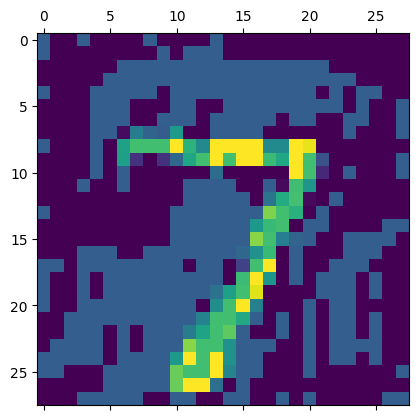

In [19]:
plt.matshow(x_test_adv[0, :, :, 0])
plt.show()

## Carlini&Wagner Infinity-norm attack

Create a ART Carlini&Wagner Infinity-norm attack.

In [20]:
attack_cw = CarliniLInfMethod(classifier=classifier,
                              max_iter=100,
                              learning_rate=0.01,
                              initial_const=1e0,
                              largest_const=2e0)

Generate adversarial test data.

In [21]:
x_test_adv = attack_cw.generate(x_test)

C&W L_inf:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluate accuracy on adversarial test data and calculate average perturbation.

In [22]:
y_test_pred = np.argmax(model(x_test_adv), axis=1)
accuracy_test_adv = np.sum(y_test_pred == y_test) / y_test.shape[0]
perturbation = np.mean(np.abs((x_test_adv - x_test)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test_adv * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 10.00%
Average perturbation: 0.03


Visualise the first adversarial test sample.

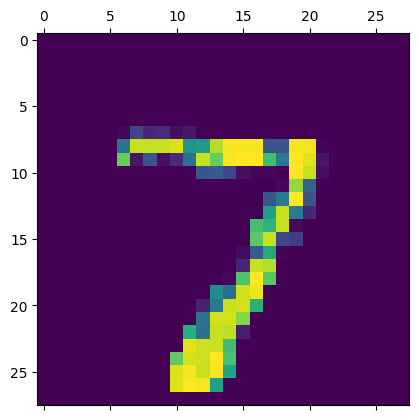

In [23]:
plt.matshow(x_test_adv[0, :, :, 0])
plt.show()

# TensorFlow with custom function

Reshape dataset in feature vectors because the model in this example requires feature vectors.

In [43]:
x_train = x_train.reshape((60000, 784))
x_test = x_test.reshape((x_test.shape[0], 784))

Create input pipelines for training and testing

In [45]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

Create variables and keep track of them

In [46]:
W = tf.Variable(initial_value=tf.random.normal(shape=(784, 10)), name="W")
b = tf.Variable(tf.zeros(shape=(10)), name="b")

In [44]:
optimizer = tf.keras.optimizers.legacy.Adam()

Define a function representing the model

In [47]:
@tf.function
def forward(x, training=None):
    x = tf.matmul(x, W) + b
    denominator = tf.expand_dims(tf.reduce_sum(tf.exp(x), axis=1), axis=1)
    softmax = (1.0 / denominator) * tf.exp(x)
    return softmax

Define the training step.

In [48]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = forward(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, [W, b])
    optimizer.apply_gradients(zip(gradients, [W, b]))

    train_loss(loss)
    train_accuracy(labels, predictions)

Define the testing step.

In [49]:
@tf.function
def test_step(images, labels):
    predictions = forward(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

Fit the model on training data and collect metrics for training and testing.

In [50]:
epochs = 3

for epoch in range(epochs):
    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    template = 'Epoch {}, Loss: {:4.2f}, Accuracy: {:4.2f}, Test Loss: {:4.2f}, Test Accuracy: {:4.2f}'
    print(template.format(epoch + 1,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          test_loss.result(),
                          test_accuracy.result() * 100))

Epoch 1, Loss: 0.82, Accuracy: 85.42, Test Loss: 0.36, Test Accuracy: 87.50
Epoch 2, Loss: 0.83, Accuracy: 84.71, Test Loss: 0.30, Test Accuracy: 90.00
Epoch 3, Loss: 0.80, Accuracy: 84.90, Test Loss: 0.26, Test Accuracy: 91.67


Evaluate model accuracy on test data.

In [51]:
y_test_pred = np.argmax(forward(x_test), axis=1)
accuracy_test = np.sum(y_test_pred == y_test) / y_test.shape[0]
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy on test data: 100.00%


Create a ART TensorFlow v2 classifier for the TensorFlow custom model function.

In [52]:
classifier = TensorFlowV2Classifier(model=forward, nb_classes=10, input_shape=(28, 28, 1),
                                    loss_object=loss_object, clip_values=(0, 1), channels_first=False)

## Fast Gradient Sign Method attack

Create a ART Fast Gradient Sign Method attack.

In [53]:
attack_fgsm = FastGradientMethod(estimator=classifier)

Generate adversarial test data.

In [54]:
x_test_adv = attack_fgsm.generate(x_test)

Evaluate accuracy on adversarial test data and calculate average perturbation.

In [55]:
y_test_pred = np.argmax(forward(x_test_adv), axis=1)
accuracy_test_adv = np.sum(y_test_pred == y_test) / y_test.shape[0]
perturbation = np.mean(np.abs((x_test_adv - x_test)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test_adv * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 0.00%
Average perturbation: 0.17


Visualise the first adversarial test sample.

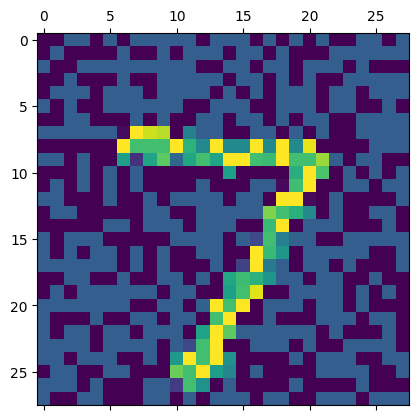

In [56]:
plt.matshow(x_test_adv[0, :].reshape((28, 28)))
plt.show()

## Carlini&Wagner Infinity-norm attack

Create a ART Carlini&Wagner Infinity-norm attack.

In [57]:
attack_cw = CarliniLInfMethod(classifier=classifier,
                              max_iter=100,
                              learning_rate=0.01,
                              initial_const=1e0,
                              largest_const=2e0)

Generate adversarial test data.

In [58]:
%%capture
x_test_adv = attack_cw.generate(x_test);

Evaluate accuracy on adversarial test data and calculate average perturbation.

In [59]:
y_test_pred = np.argmax(forward(x_test_adv), axis=1)
accuracy_test_adv = np.sum(y_test_pred == y_test) / y_test.shape[0]
perturbation = np.mean(np.abs((x_test_adv - x_test)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test_adv * 100))
print('Average perturbation: {:4.6f}'.format(perturbation))

Accuracy on adversarial test data: 0.00%
Average perturbation: 0.009456


Visualise the first adversarial test sample.

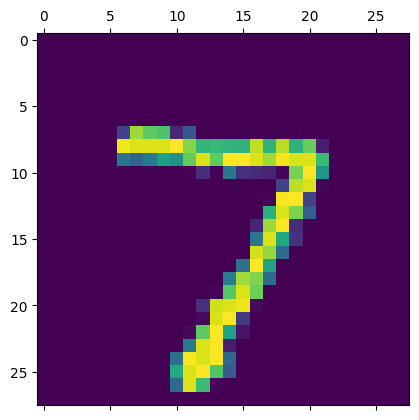

In [60]:
plt.matshow(x_test_adv[0, :].reshape((28, 28)))
plt.show()